<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span></li><li><span><a href="#VQD-Example" data-toc-modified-id="VQD-Example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>VQD Example</a></span></li><li><span><a href="#Do-statistics" data-toc-modified-id="Do-statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do statistics</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plots</a></span></li></ul></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$

This leads to a spectrum of $E_0^{\pm} = \pm(\epsilon_0 + \epsilon_1)/2$, $E_1^{\pm} = \pm \sqrt{\epsilon^2 + 4V^2}/2$, where $\epsilon^2 = (\epsilon_0 - \epsilon_1)^2$.
The eigenvalues are calculated in this [notebook](https://colab.research.google.com/drive/18IyDfCYlMx957260MSwvJtUeTcAJFnza?usp=sharing):

[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [1]:
import sys
sys.path.append('../../')

# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA, SPSA, L_BFGS_B
from qiskit.circuit.library import TwoLocal

# VOLTA
from VOLTA.VQD import VQD
from VOLTA.utils import classical_solver
from VOLTA.Hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

In [2]:
EPSILONS = [3, 3]
V = -2
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  1.5 * ZI,
  1.5 * IZ,
  -1.0 * XX,
  -1.0 * YY
])


In [3]:
eigenvalues, eigenvectors = classical_solver(hamiltonian)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-3. -2.  2.  3.]


In [4]:
from itertools import product
# Get the ideal count
ideal_dict = {}

bin_combinations = list(product(['0','1'], repeat=hamiltonian.num_qubits))
for i, eigvect in enumerate(np.abs(eigenvectors)**2):
    dic = {}
    for ind, val in enumerate(bin_combinations):
        val = ''.join(val)
        dic[val] = eigvect[ind]
    ideal_dict[i] = dic

# VQD Example

In [53]:
from qiskit.aqua import QuantumInstance

# Define Optimizer
# optimizer = COBYLA()
optimizer = SPSA(maxiter=250, c1=.5, last_avg=30)
# optimizer = L_BFGS_B()

# Define Backend
# backend = BasicAer.get_backend('qasm_simulator')
backend = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'),
                          shots=10000)

# Define ansatz
ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=3)

# Run algorithm
Algo = VQD(hamiltonian=hamiltonian,
            ansatz=ansatz,
            n_excited_states=3,
            beta=10.,
            optimizer=optimizer,
            backend=backend)

Algo.run()      
vqd_energies = Algo.energies
vqd_states = Algo.states

Calculating excited state 0
Calculating excited state 1
Calculating excited state 2
Calculating excited state 3


In [54]:
from copy import copy
# Create states and measure them
states = []
for ind, state in enumerate(vqd_states):
    states.append(copy(state))
    states[ind].measure_all()

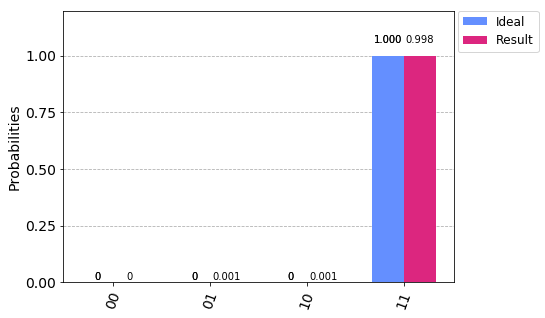

In [55]:
from qiskit import execute
from qiskit.visualization import plot_histogram

backend = BasicAer.get_backend('qasm_simulator')
count = execute(states[0], backend=backend, shots=10000).result().get_counts()
plot_histogram([ideal_dict[0], count],legend=['Ideal','Result'])

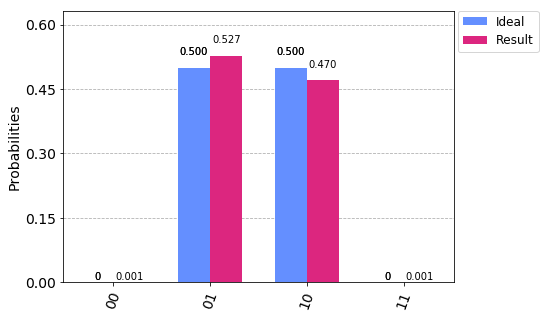

In [56]:
count = execute(states[1], backend=backend, shots=10000).result().get_counts()
plot_histogram([ideal_dict[1], count],legend=['Ideal','Result'])

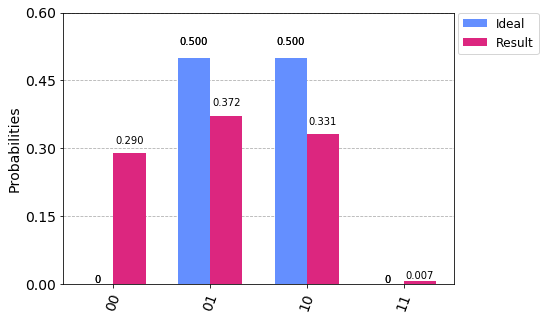

In [57]:
count = execute(states[2], backend=backend, shots=10000).result().get_counts()
plot_histogram([ideal_dict[2], count],legend=['Ideal','Result'])

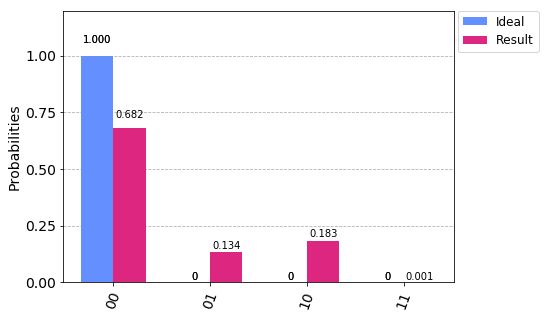

In [58]:
count = execute(states[3], backend=backend, shots=10000).result().get_counts()
plot_histogram([ideal_dict[3], count],legend=['Ideal','Result'])

In [59]:
eigenvalues

array([-3., -2.,  2.,  3.])

In [60]:
vqd_energies

[-2.9919000000000002,
 -1.8564000000000003,
 2.4507000000000008,
 2.8733999999999984]

In [61]:
n_1_sim, n_2_sim = 1, 2
n_1_vqd, n_2_vqd = 1, 2
print(f"Gap Exact: {(eigenvalues[n_2_sim] - eigenvalues[n_1_sim])/2}")
print(f"Gap VQD: {(vqd_energies[n_2_vqd] - vqd_energies[n_1_vqd])/2}")

Gap Exact: 2.0
Gap VQD: 2.1535500000000005


# Do statistics

In [87]:
from tqdm import tqdm
from qiskit.aqua import QuantumInstance

es_1 = []
es_2 = []

n = 50

for _ in tqdm(range(n)):
    # Define Optimizer
    optimizer = COBYLA()

    # Define Backend
    # backend = BasicAer.get_backend('qasm_simulator')
    backend = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'),
                              shots=10000)

    # Define ansatz
    ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=2)

    # Run algorithm
    Algo = VQD(hamiltonian=hamiltonian,
                ansatz=ansatz,
                n_excited_states=2,
                beta=10.,
                optimizer=optimizer,
                backend=backend)

    Algo.run(0)      
    vqd_energies = Algo.energies
    es_1.append(vqd_energies[1])
    es_2.append(vqd_energies[2])

100%|██████████| 50/50 [2:15:41<00:00, 144.26s/it]  


In [88]:
np.savetxt("groundstate.txt", es_1)
np.savetxt("excitedstate.txt", es_2)

In [89]:
print(f"Ground State: {np.round(np.mean(es_1),3)} +/- {np.round(np.std(es_1),3)} | Expected: {eigenvalues[1]}")
print(f"Excited State: {np.round(np.mean(es_2),3)} +/- {np.round(np.std(es_2),3)} | Expected: {eigenvalues[2]}")

Ground State: -1.807 +/- 0.324 | Expected: -2.0
Excited State: 2.443 +/- 0.424 | Expected: 2.0


In [90]:
np.round(np.mean(es_2) - np.mean(es_1), 3)/2

2.1245

## Plots

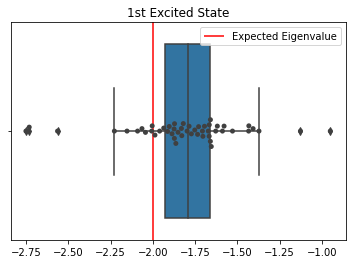

In [94]:
import seaborn as sns

sns.boxplot(x=es_1)
ax=sns.swarmplot(x=es_1, color="0.25")
ax.set_title("1st Excited State")
ax.vlines(x=eigenvalues[1], ymin=-10, ymax=10, label='Expected Eigenvalue',color='r')
plt.legend()
plt.show()

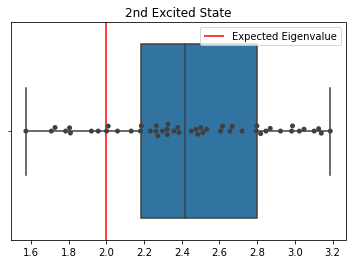

In [92]:
sns.boxplot(x=es_2)
ax=sns.swarmplot(x=es_2, color="0.25")
ax.set_title("2nd Excited State")
ax.vlines(x=eigenvalues[2], ymin=-10, ymax=10, label='Expected Eigenvalue',color='r')
plt.legend()
plt.show()

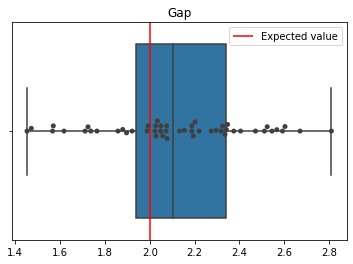

In [93]:
sns.boxplot(x=(np.array(es_2)- np.array(es_1))/2)
ax=sns.swarmplot(x=(np.array(es_2)- np.array(es_1))/2, color="0.25")
ax.set_title("Gap")
ax.vlines(x=(eigenvalues[2] - eigenvalues[1])/2, ymin=-10, ymax=10, label='Expected value',color='r')
plt.legend()
plt.show()